In [1]:
import os
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("..") 
from gcforest.gcforest import GCForest
import cmaes as cma

/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 数据以及参数

In [2]:
random_seed = 42

其余基本模型的参数都是sklearn默认的

设置深度森林参数：最大层数20，连续5层没有效果（WF1）提升则停止，每一层：4个随机森林，3个决策树，1个逻辑回归

In [3]:
def get_toy_config():
    config = {}
    ca_config = {}
    ca_config["random_state"] = random_seed
    ca_config["max_layers"] = 20
    ca_config["early_stopping_rounds"] = 5
    ca_config["n_classes"] = 6
    ca_config["estimators"] = []
    ca_config["estimators"].append({"n_folds": 5, "type": "RandomForestClassifier", "random_state" : random_seed})
    ca_config["estimators"].append({"n_folds": 5, "type": "RandomForestClassifier", "random_state" : random_seed})
    ca_config["estimators"].append({"n_folds": 5, "type": "RandomForestClassifier", "random_state" : random_seed})
    ca_config["estimators"].append({"n_folds": 5, "type": "RandomForestClassifier", "random_state" : random_seed})
    ca_config["estimators"].append({"n_folds": 5, "type": "DecisionTreeClassifier"})
    ca_config["estimators"].append({"n_folds": 5, "type": "DecisionTreeClassifier"})
    ca_config["estimators"].append({"n_folds": 5, "type": "DecisionTreeClassifier"})
    ca_config["estimators"].append({"n_folds": 5, "type": "LogisticRegression"})
    config["cascade"] = ca_config
    return config

In [4]:
path = os.getcwd()+'/../data/20122018freshwater_four_feature.csv'
data = pd.read_csv(path, na_values = np.nan)

In [5]:
# training/valid/test: 0.6/0.2/0.2, 各数据集划分的时候要注意
X = data.drop(['本周水质'], axis=1).values # Series
y = data['本周水质'].values-1 # 转换标记为0开始，因为argmax()的范围为0-n
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                       stratify = y, random_state = random_seed)
# Z-score
clean_pipeline = Pipeline([('imputer', preprocessing.Imputer(missing_values='NaN',strategy="median")),
                           ('std_scaler', preprocessing.StandardScaler()),])
X_train = clean_pipeline.fit_transform(X_train)
X_test = clean_pipeline.fit_transform(X_test)
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.25, 
                                       stratify = y_train, random_state = random_seed)
X_train = X_train2
y_train = y_train2

# Base Model Pre-train

In [6]:
config = get_toy_config()

# models = [
#     LogisticRegression(),
#     LinearDiscriminantAnalysis(),
#     SVC(probability=True),
#     DecisionTreeClassifier(),
#     ExtraTreeClassifier(),
#     GaussianNB(),
#     KNeighborsClassifier(),
#     RandomForestClassifier(random_state=random_seed),
#     ExtraTreesClassifier(random_state=random_seed),
#     GCForest(config)
# ]


# 除去所有表现优异的树模型，保留3个基础的机器学习模型
models = [
    LogisticRegression(),
    LinearDiscriminantAnalysis(),
    SVC(probability=True),
    GaussianNB(),
    KNeighborsClassifier(),
]

In [7]:
y_pred_proba_all = [] # 各模型权重参数

test_entries = [] # 各基模型测试集结果
train_entries = [] # 各基模型训练集结果

for model in models:
    model_name = model.__class__.__name__
    if model_name == 'GCForest':
        model.fit_transform(X_train, y_train, X_test, y_test)
    else:
        model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_valid) # 20%验证集上的概率向量，为训练权重做准备
    
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)

    train_entries.append((model_name, f1_train, acc_train))
    test_entries.append((model_name, f1_test, acc_test))
    y_pred_proba_all.append(y_pred_proba)
    
train_df = pd.DataFrame(train_entries, columns=['model_name', 'train_f1_weighted', 'train_accuracy'])
test_df = pd.DataFrame(test_entries, columns=['model_name', 'test_f1_weighted', 'test_accuracy'])

/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [8]:
print("Results on training data")
train_df

Results on training data


,model_name,train_f1_weighted,train_accuracy
0,LogisticRegression,0.613569,0.666220
1,LinearDiscriminantAnalysis,0.567391,0.617525
2,SVC,0.894935,0.896410
3,GaussianNB,0.812608,0.814391
4,KNeighborsClassifier,0.938284,0.938510


In [9]:
print("Results on test data")
test_df

Results on test data


,model_name,test_f1_weighted,test_accuracy
0,LogisticRegression,0.620574,0.670980
1,LinearDiscriminantAnalysis,0.576099,0.625019
2,SVC,0.894545,0.895880
3,GaussianNB,0.822296,0.824037
4,KNeighborsClassifier,0.897799,0.897813


# 训练权重

In [10]:
y_pred_proba_all = np.asarray(y_pred_proba_all)
np.save("../npy/NCE_proba_of_5models.npy", y_pred_proba_all)

In [11]:
# 直接载入各个模型在验证集的概率向量，仅在懒得pre train的时候使用
# y_pred_proba_all = np.load("../npy/NCE_proba_of_10models.npy")

## Use NCE function to get the weights

In [30]:
def trainNCE(y_valid, y_pred_proba_all, model_num):
    classifier_num = model_num
    population_num = 1000
    retain_population_num = 100
    max_iteration = 50
    population_weights = np.zeros((population_num, classifier_num))
    population_retain_weights = np.zeros((retain_population_num, classifier_num))
    population_score = []
    population_retain_score = []

    all_best_weights = np.zeros((max_iteration, classifier_num)) # 某次训练时，所有迭代步骤中最好的种群的权重
    all_best_f1s = np.zeros(max_iteration) # 某次训练时，每次迭代都取精英种群中最高的f1，构成这个“最高f1数组”
    all_mean_f1s = np.zeros(max_iteration) # 某次训练时，每次迭代都取精英种群f1的均值，构成这个“平均f1数组”

    mu = np.zeros(classifier_num)
    sigma = np.ones(classifier_num)


    # 在验证集集上: 训练每个基学习器的投票参数
    for i in range(max_iteration):
        print("Iteration: %d" %(i))
        # 该次迭代的所有种群们
        population_score = np.zeros(population_num)
        population_weights = np.zeros((population_num, classifier_num))
        # 该次迭代的优势种群们
        population_retain_score = np.zeros(retain_population_num)
        population_retain_weights = np.zeros((retain_population_num, classifier_num))

        # 生成所有种群
        for j in range(classifier_num):
            w = np.random.normal(mu[j], sigma[j]+700/(i+1), population_num)
#             w = np.random.normal(mu[j], sigma[j], population_num)
            population_weights[:,j] = w

        # 映射所有种群的权重至[0:1]
        for j in range(population_num):
            w2 = np.zeros(classifier_num)
            for k in range(classifier_num):
                w2[k] = np.exp(-population_weights[j][k]*population_weights[j][k])
#                 w2[k] = np.exp(population_weights[j][k])/np.sum(np.exp(population_weights[j]))
            population_weights[j] = w2

        # 计算所有种群得分
        for j in range(population_num):
            y_pred_ensemble_proba = np.zeros((len(y_valid), 6)) # 集成器概率向量
            # 为每一个基学习器乘上权重
            for k in range(classifier_num):
                y_pred_ensemble_proba += y_pred_proba_all[k] * population_weights[j][k]
            y_pred_ensemble = np.argmax(y_pred_ensemble_proba, axis=1)
#             print("esemble:",y_pred_ensemble)
#             print("true",y_valid)
            f1 = f1_score(y_valid, y_pred_ensemble, average="weighted")
            population_score[j] = f1

        # 所有种群得分按降序排列
        retain_index = np.argsort(-np.array(population_score))[:retain_population_num]

        # 记录该次迭代中的优势种群们
        population_retain_weights = population_weights[retain_index] # 精英样本权重
        population_retain_score = np.array(population_score)[retain_index] # 精英样本得分

        # 记录每次迭代最好的种群和value
        all_best_weights[i] = population_retain_weights[0]
        all_best_f1s[i] = population_retain_score[0] # 最高得分
        all_mean_f1s[i] = np.mean(population_retain_score) # 精英样本平均得分
        # 更新mu，sigma为优势种群们的分布
        mu = np.mean(population_retain_weights, axis = 0)
        sigma = np.std(population_retain_weights, axis = 0) #default: ddof = 0, The divisor used in calculations is N - ddof
        # print("mu\n",mu)
        # print("sigma\n", sigma)
        # print("Weighted F1 Score after rank")
        # print(population_retain_score)
        # print("Weights")
        # print(population_retain_weights)
    
    # 权重训练完毕
    print("==================Finish training==================")
    last_weight = population_retain_weights[0] # 最后一轮迭代精英样本中具有最高F1的权重
    last_f1 = all_best_f1s[-1] # 最后一轮迭代中精英样本中的最高F1
    best_f1 = all_best_f1s[np.argmax(all_best_f1s)] # 所有轮迭代中最高的F1
    best_weight = all_best_weights[np.argmax(all_best_f1s)] # 所有轮迭代中具有最高F1
    
    print("Best F1 in last iteration: %f" % (last_f1))
    print("Last weight in last iteration: %s" %(last_weight))

    print("Best F1 in all iterations: %f" % (best_f1))
    print("Best weight in all iterations: %s" %(best_weight))
    
    print("Last mu\n", mu)
    print("Last sigma\n", sigma)
    
    plt.figure(figsize=(10,6))
    plt.plot(all_best_f1s[:25], 'b', label = 'Best weighted F1 score of elite samples')
    plt.plot(all_mean_f1s[:25], 'r', label = 'Mean weighted F1 score of elite samples')
    plt.xlabel('Iteration')
    plt.ylabel('Weighted F1 score')
    plt.legend(frameon=False)
    plt.grid(True)
    # plt.savefig('../img/weighed_F1_iteration(1-10).eps',format='eps')
    return last_weight

## Use CMAES function to get the weights

In [31]:
def trainCMAES(y_valid, y_pred_proba_all, model_num):
    es = cma.CMAEvolutionStrategy(model_num * [0], 0.5)
#     help(cma)
#     help(es)
    score = "f1_weighted"
#     score = "accuracy"
    while not es.stop():
        solutions = es.ask()
        es.tell(solutions, [cma.ff.water_ensemble(x, y_pred_proba_all, y_valid, metric=score) for x in solutions])
        es.logger.add()  # write data to disc to be plotted
        es.disp()
    # 训练完毕
    es.result_pretty()  # pretty print result
    cma.plot()    
    weights = np.exp(es.result.xbest)/np.sum(np.exp(es.result.xbest))
    return weights

## 训练基模型的权重

Iteration: 0


/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
==================Finish training==================
Best F1 in last iteration: 0.909103
Last weight in last iteration: [5.30099214e-16 4.13222677e-97 2.29547031e-05 1.41943724e-22
 2.32604143e-05]
Best F1 in all iterations: 0.913740
Best weight in all iterations: [1.34561029e-022 4.37359884e-312 3.91121317e-001 3.64084144

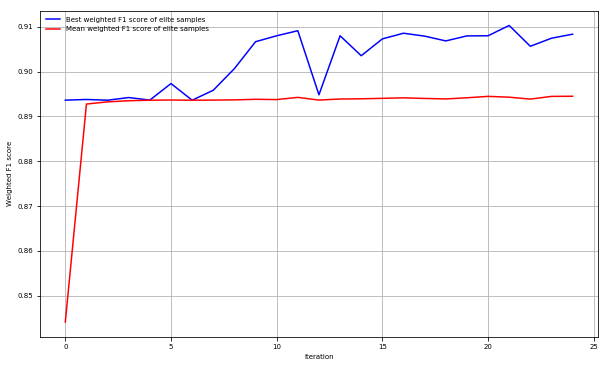

In [32]:
NCE_weights = trainNCE(y_valid, y_pred_proba_all, model_num=5)

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=409365, Wed Apr  3 21:45:53 2019)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -9.054554465063916e-01 1.0e+00 5.71e-01  5e-01  6e-01 0:00.0
    2     16 -9.055455068087885e-01 1.3e+00 6.38e-01  6e-01  7e-01 0:00.0
    3     24 -9.062316248900005e-01 1.4e+00 6.16e-01  5e-01  6e-01 0:00.1
WARNING (iteration=69):  flat fitness (f=-0.914928, sigma=3.01e-02).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (iteration=69):  flat fitness (f=-0.914928, sigma=3.01e-02).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (iteration=70):  flat fitness (f=-0.914928, sigma=3.15e-02).
                    For small sigma, this could indicate 

WARNING (iteration=88):  flat fitness (f=-0.914928, sigma=1.46e-02).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (iteration=88):  flat fitness (f=-0.914928, sigma=1.46e-02).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
termination on tolfun=1e-11
termination on tolfunhist=1e-12
termination on flat fitness=please (re)consider how to compute the fitness more elaborately if sigma=1.46e-02 is large
final/bestever f-value = -9.149277e-01 -9.149410e-01
incumbent solution: [-3.372375701780566, -4.153200827708871, 1.3619252140664084, 0.7520016845367713, 1.447190594162319]
std deviation: [0.024602286758573132, 0.019265719161773335, 0.0049109256699471585, 0.004963496999074173, 0.0046806233553652815]


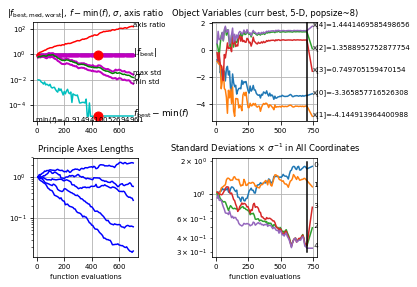

In [33]:
CMAES_weights = trainCMAES(y_valid, y_pred_proba_all, model_num=5)

In [34]:
np.save("../npy/NCE_weights_5.npy", NCE_weights)
np.save("../npy/CMAES_weights_5.npy", CMAES_weights)

# 测试

代入权重，在3个集合上计算ACC和F1

- 训练集（总样本数量的60%）X_train
- 验证集（总样本数量的20%，调参数，用CMAES得到权重）X_valid
- 测试集（总样本数的20%）X_test
- 各模型稳定性基于交叉验证，在除测试集外的80%上做5折 X_train

In [35]:
print("==================== NCE weights ====================")
print(NCE_weights)
print("==================== CMAES weights ====================")
print(CMAES_weights)

==================== NCE weights ====================
[5.30099214e-16 4.13222677e-97 2.29547031e-05 1.41943724e-22
 2.32604143e-05]
==================== CMAES weights ====================
[0.00255831 0.00118493 0.38039359 0.20452462 0.41133857]


### ACC

In [36]:
# 取训练好的模型
for model in models:
    model_name = model.__class__.__name__
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)
    test_pred = model.predict(X_test)
    print("=================" + model_name + "=================")
    train_cm = confusion_matrix(y_train, train_pred)
    valid_cm = confusion_matrix(y_valid, valid_pred)
    test_cm = confusion_matrix(y_test, test_pred)
    i=0
    train_acc_all = np.zeros(6)
    for c in train_cm:
        train_acc_all[i] = c[i]/np.sum(c)
        print("%d train_acc: %.2f" %(i+1, 100*train_acc_all[i]))
        i=i+1
    print("average: %.2f" % (100*np.mean(train_acc_all)))
    i=0
    valid_acc_all = np.zeros(6)
    for c in valid_cm:
        valid_acc_all[i] = c[i]/np.sum(c)
        print("%d valid_acc: %.2f" %(i+1, 100*valid_acc_all[i]))
        i=i+1
    print("average: %.2f" % (100*np.mean(valid_acc_all)))
    i=0
    test_acc_all = np.zeros(6)
    for c in test_cm:
        test_acc_all[i] = c[i]/np.sum(c)
        print("%d test_acc: %.2f" %(i+1, 100*test_acc_all[i]))
        i=i+1
    print("average: %.2f" % (100*np.mean(test_acc_all)))

=================LogisticRegression=================
1 train_acc: 3.08
2 train_acc: 99.21
3 train_acc: 57.22
4 train_acc: 45.05
5 train_acc: 0.00
6 train_acc: 77.02
average: 46.93
1 valid_acc: 3.07
2 valid_acc: 99.13
3 valid_acc: 58.50
4 valid_acc: 45.21
5 valid_acc: 0.00
6 valid_acc: 78.79
average: 47.45
1 test_acc: 5.74
2 test_acc: 99.51
3 test_acc: 55.17
4 test_acc: 48.08
5 test_acc: 0.00
6 test_acc: 80.19
average: 48.11
=================LinearDiscriminantAnalysis=================
1 train_acc: 0.00
2 train_acc: 99.90
3 train_acc: 38.08
4 train_acc: 50.62
5 train_acc: 28.33
6 train_acc: 44.57
average: 43.58
1 valid_acc: 0.00
2 valid_acc: 99.85
3 valid_acc: 38.49
4 valid_acc: 51.42
5 valid_acc: 26.94
6 valid_acc: 45.45
average: 43.69
1 test_acc: 0.00
2 test_acc: 99.92
3 test_acc: 38.58
4 test_acc: 52.83
5 test_acc: 29.97
6 test_acc: 47.32
average: 44.77
=================SVC=================
1 train_acc: 64.64
2 train_acc: 93.62
3 train_acc: 89.20
4 train_acc: 90.07
5 train_acc: 87.35


In [37]:
# - 计算NCE（1-5）

population_best_weight = NCE_weights

classifier_num = 5

# 所有学习器都输出概率向量，最后投票
y_train_pred_proba_all = []
y_valid_pred_proba_all = []
y_test_pred_proba_all = []

# 取训练好的模型，计算各模型”验证集“上输出概率向量
for model in models:
    train_pred_proba = model.predict_proba(X_train)
    valid_pred_proba = model.predict_proba(X_valid)
    test_pred_proba = model.predict_proba(X_test)
    y_train_pred_proba_all.append(train_pred_proba)
    y_valid_pred_proba_all.append(valid_pred_proba)
    y_test_pred_proba_all.append(test_pred_proba)
    
y_train_pred_ensemble_proba = np.zeros((len(y_train), 6)) # 初始化集成器概率向量
y_valid_pred_ensemble_proba = np.zeros((len(y_valid), 6)) # 初始化集成器概率向量
y_test_pred_ensemble_proba = np.zeros((len(y_test), 6)) # 初始化集成器概率向量

# 为每一个基学习器乘上权重
for k in range(classifier_num):
    y_train_pred_ensemble_proba += y_train_pred_proba_all[k] * population_best_weight[k]
    y_valid_pred_ensemble_proba += y_valid_pred_proba_all[k] * population_best_weight[k]
    y_test_pred_ensemble_proba += y_test_pred_proba_all[k] * population_best_weight[k]
y_train_pred_ensemble = np.argmax(y_train_pred_ensemble_proba, axis=1)
y_valid_pred_ensemble = np.argmax(y_valid_pred_ensemble_proba, axis=1)
y_test_pred_ensemble = np.argmax(y_test_pred_ensemble_proba, axis=1)

# 计算各水质等级的得分
print("=================NCE(5)=================")
train_cm = confusion_matrix(y_train, y_train_pred_ensemble)
valid_cm = confusion_matrix(y_valid, y_valid_pred_ensemble)
test_cm = confusion_matrix(y_test, y_test_pred_ensemble)
i=0
train_acc_all = np.zeros(6)
for c in train_cm:
    train_acc_all[i] = c[i]/np.sum(c)
    print("%d train_acc: %.2f" %(i+1, 100*train_acc_all[i]))
    i=i+1
print("average: %.2f" % (100*np.mean(train_acc_all)))
i=0
valid_acc_all = np.zeros(6)
for c in valid_cm:
    valid_acc_all[i] = c[i]/np.sum(c)
    print("%d valid_acc: %.2f" %(i+1, 100*valid_acc_all[i]))
    i=i+1
print("average: %.2f" % (100*np.mean(valid_acc_all)))
i=0
test_acc_all = np.zeros(6)
for c in test_cm:
    test_acc_all[i] = c[i]/np.sum(c)
    print("%d test_acc: %.2f" %(i+1, 100*test_acc_all[i]))
    i=i+1
print("average: %.2f" % (100*np.mean(test_acc_all)))

=================NCE(5)=================
1 train_acc: 81.33
2 train_acc: 95.84
3 train_acc: 93.07
4 train_acc: 94.43
5 train_acc: 91.15
6 train_acc: 96.58
average: 92.07
1 valid_acc: 76.23
2 valid_acc: 94.24
3 valid_acc: 91.25
4 valid_acc: 91.78
5 valid_acc: 76.43
6 valid_acc: 94.64
average: 87.43
1 test_acc: 80.53
2 test_acc: 93.63
3 test_acc: 90.06
4 test_acc: 92.32
5 test_acc: 87.54
6 test_acc: 96.97
average: 90.18


In [29]:
# - 计算CMAES（1-5）

population_best_weight = CMAES_weights

classifier_num = 5

# 所有学习器都输出概率向量，最后投票
y_train_pred_proba_all = []
y_valid_pred_proba_all = []
y_test_pred_proba_all = []

# 取训练好的模型，计算各模型”验证集“上输出概率向量
for model in models:
    train_pred_proba = model.predict_proba(X_train)
    valid_pred_proba = model.predict_proba(X_valid)
    test_pred_proba = model.predict_proba(X_test)
    y_train_pred_proba_all.append(train_pred_proba)
    y_valid_pred_proba_all.append(valid_pred_proba)
    y_test_pred_proba_all.append(test_pred_proba)
    
y_train_pred_ensemble_proba = np.zeros((len(y_train), 6)) # 初始化集成器概率向量
y_valid_pred_ensemble_proba = np.zeros((len(y_valid), 6)) # 初始化集成器概率向量
y_test_pred_ensemble_proba = np.zeros((len(y_test), 6)) # 初始化集成器概率向量

# 为每一个基学习器乘上权重
for k in range(classifier_num):
    y_train_pred_ensemble_proba += y_train_pred_proba_all[k] * population_best_weight[k]
    y_valid_pred_ensemble_proba += y_valid_pred_proba_all[k] * population_best_weight[k]
    y_test_pred_ensemble_proba += y_test_pred_proba_all[k] * population_best_weight[k]
y_train_pred_ensemble = np.argmax(y_train_pred_ensemble_proba, axis=1)
y_valid_pred_ensemble = np.argmax(y_valid_pred_ensemble_proba, axis=1)
y_test_pred_ensemble = np.argmax(y_test_pred_ensemble_proba, axis=1)

# 计算各水质等级的得分
print("=================CMAES=================")
train_cm = confusion_matrix(y_train, y_train_pred_ensemble)
valid_cm = confusion_matrix(y_valid, y_valid_pred_ensemble)
test_cm = confusion_matrix(y_test, y_test_pred_ensemble)
i=0
train_acc_all = np.zeros(6)
for c in train_cm:
    train_acc_all[i] = c[i]/np.sum(c)
    print("%d train_acc: %.2f" %(i+1, 100*train_acc_all[i]))
    i=i+1
print("average: %.2f" % (100*np.mean(train_acc_all)))
i=0
valid_acc_all = np.zeros(6)
for c in valid_cm:
    valid_acc_all[i] = c[i]/np.sum(c)
    print("%d valid_acc: %.2f" %(i+1, 100*valid_acc_all[i]))
    i=i+1
print("average: %.2f" % (100*np.mean(valid_acc_all)))
i=0
test_acc_all = np.zeros(6)
for c in test_cm:
    test_acc_all[i] = c[i]/np.sum(c)
    print("%d test_acc: %.2f" %(i+1, 100*test_acc_all[i]))
    i=i+1
print("average: %.2f" % (100*np.mean(test_acc_all)))

=================CMAES=================
1 train_acc: 81.05
2 train_acc: 96.09
3 train_acc: 93.62
4 train_acc: 94.46
5 train_acc: 90.71
6 train_acc: 96.12
average: 92.01
1 valid_acc: 76.64
2 valid_acc: 94.69
3 valid_acc: 92.15
4 valid_acc: 91.96
5 valid_acc: 78.79
6 valid_acc: 94.64
average: 88.15
1 test_acc: 80.74
2 test_acc: 94.76
3 test_acc: 91.02
4 test_acc: 92.50
5 test_acc: 88.22
6 test_acc: 96.50
average: 90.62


### F1

In [40]:
population_best_weight = NCE_weights


# 所有学习器都输出概率向量，最后投票
y_train_pred_proba_all = []
y_valid_pred_proba_all = []
y_test_pred_proba_all = []

# 取训练好的模型，计算各模型”验证集“上输出概率向量
for model in models:
    model_name = model.__class__.__name__
    train_pred_proba = model.predict_proba(X_train)
    valid_pred_proba = model.predict_proba(X_valid)
    test_pred_proba = model.predict_proba(X_test)
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)
    test_pred = model.predict(X_test)
    print("=================" + model_name + "=================")
    print(classification_report(y_train, train_pred, digits=4))
    print(classification_report(y_valid, valid_pred, digits=4))
    print(classification_report(y_test, test_pred, digits=4))

    y_train_pred_proba_all.append(train_pred_proba)
    y_valid_pred_proba_all.append(valid_pred_proba)
    y_test_pred_proba_all.append(test_pred_proba)

    
y_train_pred_ensemble_proba = np.zeros((len(y_train), 6)) # 初始化集成器概率向量
y_valid_pred_ensemble_proba = np.zeros((len(y_valid), 6)) # 初始化集成器概率向量
y_test_pred_ensemble_proba = np.zeros((len(y_test), 6)) # 初始化集成器概率向量

# 为每一个基学习器乘上权重
for k in range(classifier_num):
    y_train_pred_ensemble_proba += y_train_pred_proba_all[k] * population_best_weight[k]
    y_valid_pred_ensemble_proba += y_valid_pred_proba_all[k] * population_best_weight[k]
    y_test_pred_ensemble_proba += y_test_pred_proba_all[k] * population_best_weight[k]
y_train_pred_ensemble = np.argmax(y_train_pred_ensemble_proba, axis=1)
y_valid_pred_ensemble = np.argmax(y_valid_pred_ensemble_proba, axis=1)
y_test_pred_ensemble = np.argmax(y_test_pred_ensemble_proba, axis=1)

# 计算各水质等级的得分
print("=================NCE=================")

print(classification_report(y_train, y_train_pred_ensemble, digits=4))
print(classification_report(y_valid, y_valid_pred_ensemble, digits=4))
print(classification_report(y_test, y_test_pred_ensemble, digits=4))

=================LogisticRegression=================
             precision    recall  f1-score   support

          0     0.8654    0.0308    0.0594      1462
          1     0.6703    0.9921    0.8000      7962
          2     0.6432    0.5722    0.6056      5278
          3     0.6217    0.4505    0.5224      3283
          4     0.0000    0.0000    0.0000       893
          5     0.7904    0.7702    0.7802      1288

avg / total     0.6474    0.6662    0.6136     20166

             precision    recall  f1-score   support

          0     0.9375    0.0307    0.0595       488
          1     0.6764    0.9913    0.8042      2655
          2     0.6439    0.5850    0.6130      1759
          3     0.6338    0.4521    0.5277      1095
          4     0.0000    0.0000    0.0000       297
          5     0.7735    0.7879    0.7806       429

avg / total     0.6562    0.6707    0.6181      6723

             precision    recall  f1-score   support

          0     0.9333    0.0574    0.1

/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


=================SVC=================
             precision    recall  f1-score   support

          0     0.8607    0.6464    0.7383      1462
          1     0.8850    0.9362    0.9099      7962
          2     0.8812    0.8920    0.8865      5278
          3     0.9375    0.9007    0.9188      3283
          4     0.8914    0.8735    0.8824       893
          5     0.9686    0.9573    0.9629      1288

avg / total     0.8964    0.8964    0.8949     20166

             precision    recall  f1-score   support

          0     0.8509    0.6434    0.7328       488
          1     0.8802    0.9322    0.9054      2655
          2     0.8760    0.8874    0.8817      1759
          3     0.9239    0.8977    0.9106      1095
          4     0.8826    0.7845    0.8307       297
          5     0.9421    0.9487    0.9454       429

avg / total     0.8881    0.8884    0.8868      6723

             precision    recall  f1-score   support

          0     0.7970    0.6516    0.7170       488
 

In [41]:
# 所有学习器都输出概率向量，最后投票
population_best_weight = CMAES_weights

y_train_pred_proba_all = []
y_valid_pred_proba_all = []
y_test_pred_proba_all = []

# 取训练好的模型，计算各模型”验证集“上输出概率向量
for model in models:
    model_name = model.__class__.__name__
    train_pred_proba = model.predict_proba(X_train)
    valid_pred_proba = model.predict_proba(X_valid)
    test_pred_proba = model.predict_proba(X_test)
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)
    test_pred = model.predict(X_test)
    print("=================" + model_name + "=================")
    print(classification_report(y_train, train_pred, digits=4))
    print(classification_report(y_valid, valid_pred, digits=4))
    print(classification_report(y_test, test_pred, digits=4))

    y_train_pred_proba_all.append(train_pred_proba)
    y_valid_pred_proba_all.append(valid_pred_proba)
    y_test_pred_proba_all.append(test_pred_proba)

    
y_train_pred_ensemble_proba = np.zeros((len(y_train), 6)) # 初始化集成器概率向量
y_valid_pred_ensemble_proba = np.zeros((len(y_valid), 6)) # 初始化集成器概率向量
y_test_pred_ensemble_proba = np.zeros((len(y_test), 6)) # 初始化集成器概率向量

# 为每一个基学习器乘上权重
for k in range(classifier_num):
    y_train_pred_ensemble_proba += y_train_pred_proba_all[k] * population_best_weight[k]
    y_valid_pred_ensemble_proba += y_valid_pred_proba_all[k] * population_best_weight[k]
    y_test_pred_ensemble_proba += y_test_pred_proba_all[k] * population_best_weight[k]
y_train_pred_ensemble = np.argmax(y_train_pred_ensemble_proba, axis=1)
y_valid_pred_ensemble = np.argmax(y_valid_pred_ensemble_proba, axis=1)
y_test_pred_ensemble = np.argmax(y_test_pred_ensemble_proba, axis=1)

# 计算各水质等级的得分
print("=================CMAES=================")

print(classification_report(y_train, y_train_pred_ensemble, digits=4))
print(classification_report(y_valid, y_valid_pred_ensemble, digits=4))
print(classification_report(y_test, y_test_pred_ensemble, digits=4))

=================LogisticRegression=================
             precision    recall  f1-score   support

          0     0.8654    0.0308    0.0594      1462
          1     0.6703    0.9921    0.8000      7962
          2     0.6432    0.5722    0.6056      5278
          3     0.6217    0.4505    0.5224      3283
          4     0.0000    0.0000    0.0000       893
          5     0.7904    0.7702    0.7802      1288

avg / total     0.6474    0.6662    0.6136     20166

             precision    recall  f1-score   support

          0     0.9375    0.0307    0.0595       488
          1     0.6764    0.9913    0.8042      2655
          2     0.6439    0.5850    0.6130      1759
          3     0.6338    0.4521    0.5277      1095
          4     0.0000    0.0000    0.0000       297
          5     0.7735    0.7879    0.7806       429

avg / total     0.6562    0.6707    0.6181      6723

             precision    recall  f1-score   support

          0     0.9333    0.0574    0.1

/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


=================SVC=================
             precision    recall  f1-score   support

          0     0.8607    0.6464    0.7383      1462
          1     0.8850    0.9362    0.9099      7962
          2     0.8812    0.8920    0.8865      5278
          3     0.9375    0.9007    0.9188      3283
          4     0.8914    0.8735    0.8824       893
          5     0.9686    0.9573    0.9629      1288

avg / total     0.8964    0.8964    0.8949     20166

             precision    recall  f1-score   support

          0     0.8509    0.6434    0.7328       488
          1     0.8802    0.9322    0.9054      2655
          2     0.8760    0.8874    0.8817      1759
          3     0.9239    0.8977    0.9106      1095
          4     0.8826    0.7845    0.8307       297
          5     0.9421    0.9487    0.9454       429

avg / total     0.8881    0.8884    0.8868      6723

             precision    recall  f1-score   support

          0     0.7970    0.6516    0.7170       488
 

人为设定了10个参数的初值x0=10*[0]，sigma0=0.5, 算法包中对sigma0的描述为：

http://cma.gforge.inria.fr/apidocs-pycma/cma.evolution_strategy.CMAEvolutionStrategy.html

> initial standard deviation. The problem variables should have been scaled, such that a single standard deviation on all variables is useful and the optimum is expected to lie within about x0 +- 3*sigma0. See also options scaling_of_variables. Often one wants to check for solutions close to the initial point. This allows, for example, for an easier check of consistency of the objective function and its interfacing with the optimizer. In this case, a much smaller sigma0 is advisable.

CMAES 知乎算法专栏
https://zhuanlan.zhihu.com/p/31193293

In [39]:
# 算法默认参数

cma.CMAOptions.defaults()

{'AdaptSigma': 'True  # or False or any CMAAdaptSigmaBase class e.g. CMAAdaptSigmaTPA, CMAAdaptSigmaCSA',
 'BoundaryHandler': 'BoundTransform  # or BoundPenalty, unused when ``bounds in (None, [None, None])``',
 'CMA_active': 'True  # negative update, conducted after the original update',
 'CMA_cmean': '1  # learning rate for the mean value',
 'CMA_const_trace': 'False  # normalize trace, 1, True, "arithm", "geom", "aeig", "geig" are valid',
 'CMA_dampsvec_fac': 'np.Inf  # tentative and subject to changes, 0.5 would be a "default" damping for sigma vector update',
 'CMA_dampsvec_fade': '0.1  # tentative fading out parameter for sigma vector update',
 'CMA_diagonal': '0*100*N/popsize**0.5  # nb of iterations with diagonal covariance matrix, True for always',
 'CMA_eigenmethod': 'np.linalg.eigh  # or cma.utils.eig or pygsl.eigen.eigenvectors',
 'CMA_elitist': 'False  #v or "initial" or True, elitism likely impairs global search performance',
 'CMA_mirrormethod': '2  # 0=unconditional, 1=